In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os

os.add_dll_directory("C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.7/bin")
os.add_dll_directory("C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.7/lib")

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
from livelossplot.inputs.tf_keras import PlotLossesCallback
import tensorflow as tf

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.9.0


In [2]:
base_path = "./archive/"
train_path = base_path + "train/train/"
test_path = base_path + "test/test/"
for expression in os.listdir(train_path):
    print(str(len(os.listdir(train_path + expression))) + " " + expression + " images")


3995 angry images
436 disgust images
4097 fear images
7215 happy images
4965 neutral images
4830 sad images
3171 surprise images


In [3]:

image_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip=True)
train_generator = datagen_train.flow_from_directory(
    train_path,
    target_size=(image_size, image_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_validation.flow_from_directory(
    test_path,
    target_size=(image_size, image_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [4]:

# CNN Model
model = Sequential()

# 1st Convolution
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution
model.add(Conv2D(128, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution
model.add(Conv2D(512, (3, 3), padding='same', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution
model.add(Conv2D(512, (3, 3), padding='same', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(learning_rate=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

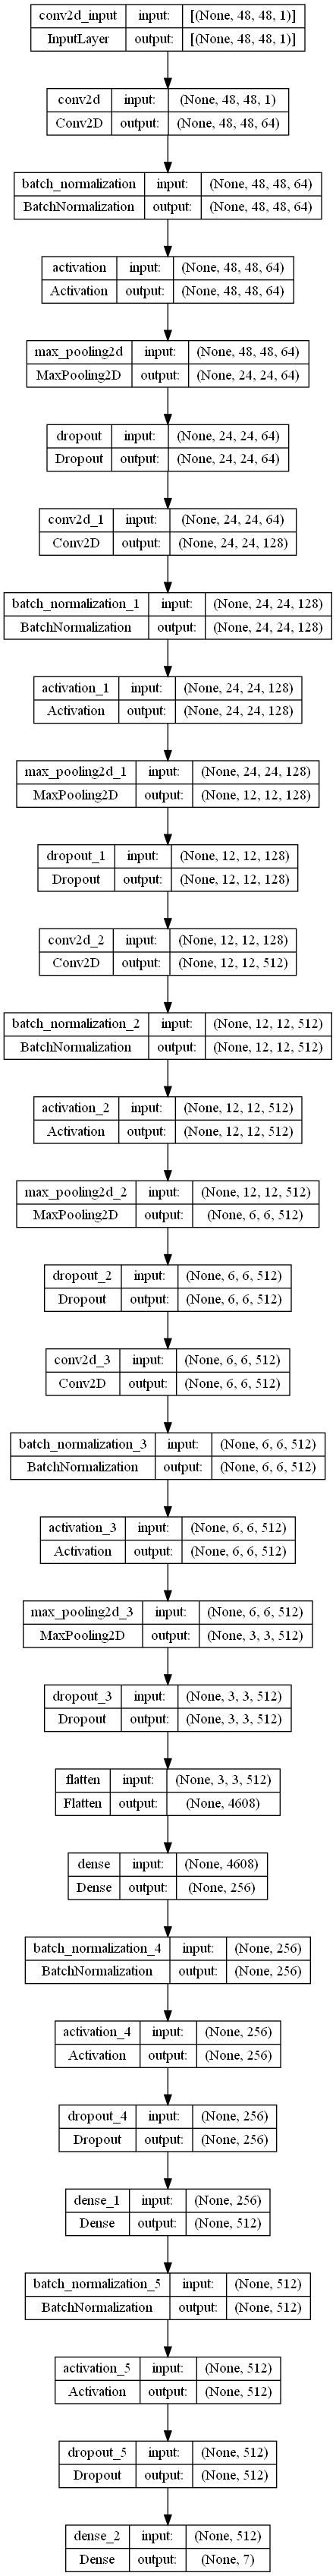

In [5]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
Image('model.png', width=400, height=200)

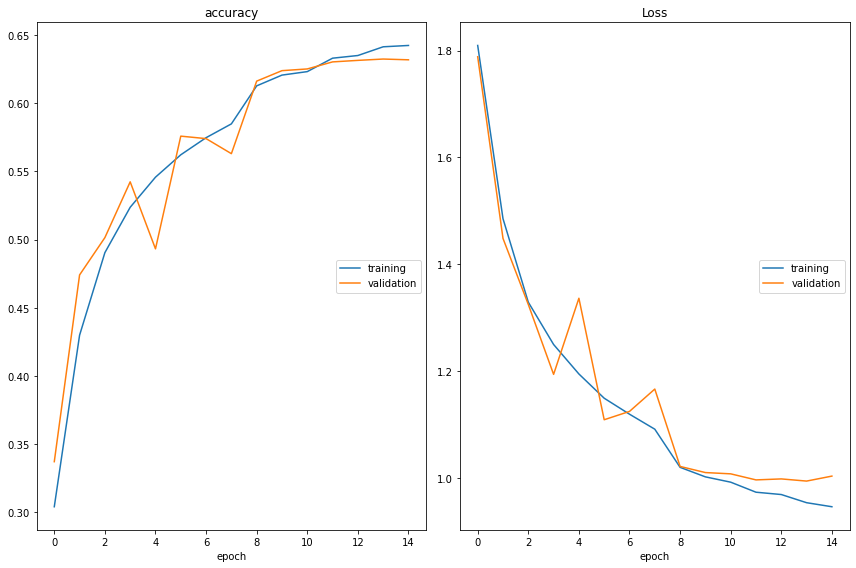

accuracy
	training         	 (min:    0.304, max:    0.642, cur:    0.642)
	validation       	 (min:    0.337, max:    0.632, cur:    0.632)
Loss
	training         	 (min:    0.946, max:    1.810, cur:    0.946)
	validation       	 (min:    0.994, max:    1.789, cur:    1.004)

Epoch 15: saving model to model_weights.h5
448/448 [==============================] - 19s 42ms/step - loss: 0.9463 - accuracy: 0.6422 - val_loss: 1.0036 - val_accuracy: 0.6317 - lr: 5.0000e-05
CPU times: total: 9min 53s
Wall time: 8min 20s


In [6]:
%%time


epochs = 15
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

reduce_learning_rate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    min_lr=0.00001,
    mode='auto')
checkpoint = ModelCheckpoint(
    'model_weights.h5',
    monitor='val_accuracy',
    save_weighs_only=True,
    mode='max',
    verbose=1
)
callbacks = [PlotLossesCallback(), checkpoint, reduce_learning_rate]

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)

In [10]:
model_json = model.to_json()
model.save_weights('model_weights.h5')
with open('model.json', 'w') as json_file:
    json_file.write(model_json)

In [13]:
from tensorflow.keras.models import model_from_json
import numpy as np
import tensorflow as tf


class FacialExpressionModel(object):
    EMOTIONS_LIST = [
        'Angry',
        'Disgust',
        'Fear',
        'Happy',
        'Neutral',
        'Sad',
        'Surprise'
    ]

    def __init__(self, model_json_file, model_weights_file):
        with open(model_json_file, 'r') as json_file:
            loaded_model_json = json_file.read()
            self.loaded_model = model_from_json(loaded_model_json)
            self.loaded_model.load_weights(model_weights_file)
            self.loaded_model.make_predict_function()

    def predict_emotion(self, img):
        self.preds = self.loaded_model.predict(img)
        return FacialExpressionModel.EMOTIONS_LIST[np.argmax(self.preds)]


In [15]:
import cv2

import numpy as np

facec = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
model = FacialExpressionModel('model.json', 'model_weights.h5')
font = cv2.FONT_HERSHEY_SIMPLEX


class VideoCamera(object):
    def __init__(self):
        self.video = cv2.VideoCapture(0)

    def __del__(self):
        self.video.release()

    def get_frame(self):
        _, fr = self.video.read()
        gray_fr = cv2.cvtColor(fr, cv2.COLOR_BGR2GRAY)
        faces = facec.detectMultiScale(gray_fr, 1.3, 5)

        for (x, y, w, h) in faces:
            fc = gray_fr[y:y + h, x:x + w]
            roi = cv2.resize(fc, (48, 48))
            pred = model.predict_emotion(roi[np.newaxis, :, :, np.newaxis])
            cv2.putText(fr, pred, (x, y), font, 1, (255, 255, 0), 2)
            cv2.rectangle(fr, (x, y), (x + w, y + h), (255, 0, 0), 2)

        return fr


In [18]:
def gen(camera):
    while True:
        frame = camera.get_frame()
        cv2.imshow('Facial Expression Recognization',frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cv2.destroyAllWindows()

In [19]:
gen(VideoCamera())

1/1 [==============================] - 0s 14ms/step
